# Rotten fruit detection using Deep Learning

## Project objective

This project aims to automatically detect **rotten fruits** (apples, bananas and oranges) from images, to assist farmers in **automated sorting** during harvesting.

We use a **Transfer learning** approach, which means we start with a model (**MobileNetV2**) pre-trained on a large dataset (ImageNet), and fine-tune it to detect rotten and fresh fruits using our custom dataset.
MobileNetV2 is a lightweight and efficient deep learning model well-suited for real-time classification tasks.

---

## Background

In smart agriculture, artificial intelligence can automate repetitive and time-sensitive tasks such as fruit sorting.  
A system equipped with a camera and a trained model can identify and remove rotten fruits **without human intervention**, saving time and improving quality control.

---

## Why MobileNetV2?

We chose **MobileNetV2** because it is a **lightweight model** optimized for devices with limited computational power, such as embedded systems (smart cameras, mobile robots, smartphones, etc.).

Compared to larger models (like ResNet or VGG), MobileNetV2:
- has fewer parameters,
- consumes less memory,
- runs faster on CPU,
- and is ideal for **real-time inference** in practical agricultural applications.


## Load and preprocess image data with ImageDataGenerator

In this step, we’ll:
- Load the training and test images from folders,
- Resize and normalize them,
- Apply data augmentation to improve generalization,
- Prepare them in batches for training.

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
train_dir = "dataset/train"
test_dir = "dataset/test"

These are the folders where images are stored.

Inside each folder, there are subfolders for each class (like freshoranges, rottenapples, etc.).

Keras uses these subfolder names to automatically assign labels.

We apply augmentation options to make the model more robust (only for training)

Data augmentation improves the model's robustness by simulating real-world variations.  
It exposes the model to rotated, zoomed, flipped, and shifted versions of the same images,  
helping it learn to generalize rather than memorize the training data.

In [3]:
import tensorflow as tf
import numpy as np
import random
import os

SEED = 123

# Set seeds for reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


In [4]:


# Image parameters
IMG_SIZE = 224 # MobileNetV2 expects 224x224 images by default
BATCH_SIZE = 32 # Common default, Images processed per training step.
                 # Using mini-batches is more memory-efficient and speeds up training.

# Create data generators,
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values (0–1)
    rotation_range=20,           # Randomly rotate images by ±20 degrees 
    zoom_range=0.2,              # Random zoom
    width_shift_range=0.2,       # Horizontal shift
    height_shift_range=0.2,      # Vertical shift
    shear_range=0.2,             # Shearing transformation, applies distortion (like slanting)
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'          # Fill in missing pixels
)

# For testing, we don’t use augmentation.
# We only normalize the images
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # one hot encoder vectors
    seed=SEED
)

# Load and preprocess test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, #we keep the order of test images fixed — this is important for later when we match predictions to true labels. 
    seed=SEED
)

# Class labels
class_names = list(train_generator.class_indices.keys())
print("Detected classes:", class_names)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.
Detected classes: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


## Visualize images from the training set

It’s important to preview some images to:
- verify the data is loaded properly,
- check if labels are correct,
- visually confirm augmentation (rotation, flip, etc.) is applied.

Classes: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


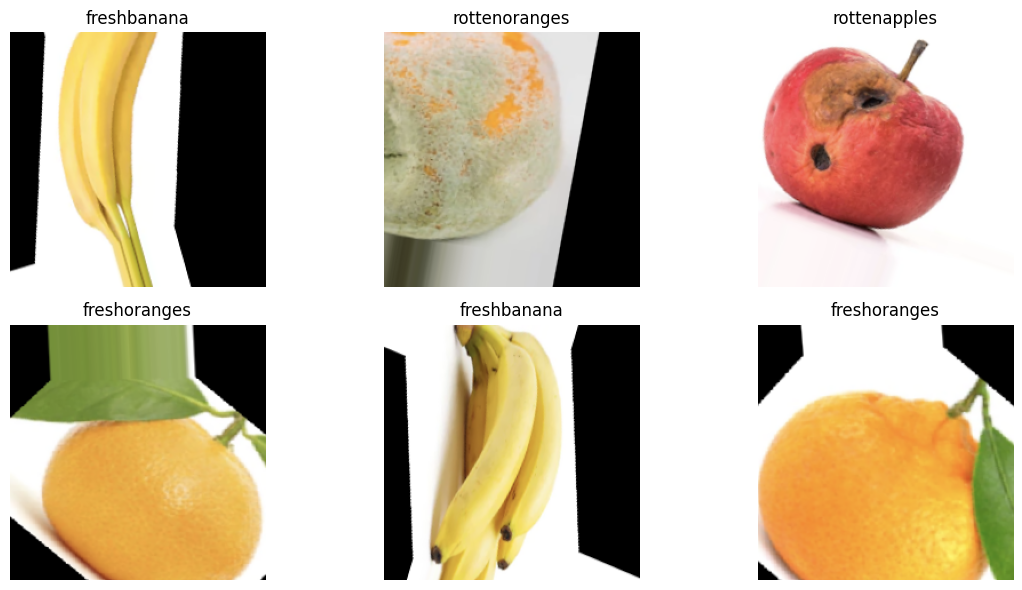

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images and labels
images, labels = next(train_generator)

# Class names (already defined earlier)
print("Classes:", class_names)

# Plot 6 sample images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


## Building the model with MobileNetV2

We’ll:
- Load MobileNetV2 with pre-trained weights from ImageNet,
- Freeze its base (so we don’t retrain all its layers),
- Add a custom classification head on top for your fruit classes (e.g., 6 classes),
- Compile the model so it’s ready for training.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the base model (without the top classification layer)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),  # matches image size and RGB channels (1 for grayscale images)
    include_top=False,        # Remove default classifier
    weights='imagenet'        # Use weights trained on ImageNet
)

# Freeze the base model so its weights are not updated during training
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)         # Reduce feature maps to a vector
x = Dense(128, activation='relu')(x)    # Fully connected layer it applies non-linearity (ReLU) so the model can learn more abstract patterns specific to dataset.
output = Dense(len(class_names), activation='softmax')(x)  # Final classifier, softmax turns outputs into a probability distribution (values between 0 and 1 that sum to 1). Used for multi-class classification.

# Combine base and new head
model = Model(inputs=base_model.input, outputs=output) # Combines the input of MobileNet with our custom head

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show summary
model.summary()


## Train the model

Now that the model architecture is ready, we can compile and train it.

We use the Adam optimizer, which generally works well for deep learning tasks (adaptive and efficient), and the categorical_crossentropy loss function, as we are dealing with a multi-class classification problem.

To prevent overfitting, we also include an early stopping callback. This stops training if the model doesn't improve on the validation set for several consecutive epochs, and restores the best weights.

ModelCheckpoint: save the best model during training

We’ll train for a maximum of 20 epochs, but early stopping may interrupt earlier if needed.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks to stop early and save best model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,  # we use test set for validation here (since no separate val set)
    epochs=10,
    callbacks=[early_stop, checkpoint]
)


c:\Users\mamyd\personal_projects\ds_portfolio\ds-projects-nmd\ds-env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8775 - loss: 0.3313

341/341 ━━━━━━━━━━━━━━━━━━━━ 468s 1s/step - accuracy: 0.9430 - loss: 0.1596 - val_accuracy: 0.9707 - val_loss: 0.0869
Epoch 2/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9741 - loss: 0.0734

341/341 ━━━━━━━━━━━━━━━━━━━━ 225s 661ms/step - accuracy: 0.9772 - loss: 0.0669 - val_accuracy: 0.9848 - val_loss: 0.0502
Epoch 3/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9819 - loss: 0.0496

341/341 ━━━━━━━━━━━━━━━━━━━━ 226s 663ms/step - accuracy: 0.9820 - loss: 0.0500 - val_accuracy: 0.9896 - val_loss: 0.0319
Epoch 4/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 218s 640ms/step - accuracy: 0.9865 - loss: 0.0388 - val_accuracy: 0.9841 - val_loss: 0.0473
Epoch 5/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 218s 638ms/step - accuracy: 0.9872 - loss: 0.0361 - val_accuracy: 0.9789 - val_loss: 0.0753
Epoch 6/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 217s 637ms/step - accuracy: 0.9850 - loss: 0.0419 - val_accuracy: 0.9889 - val_loss: 0.0357


### Training results

We trained the model for 10 full epochs with an early stopping mechanism enabled to prevent overfitting.  
Training was automatically stopped when the validation loss stopped improving for 3 consecutive epochs. 
The best performance was at **epoch 3** and the validation_loss didn't improve during eepoch 4, 5 and 6. 

- **Training accuracy** reached ~98.7%
- **Validation accuracy** reached ~98.8%
- The **training and validation accuracy remained very close**, no signs of overfitting were observed
- The best performance was at **epoch 3** with val_loss ~0.0319


## Visualize training performance

To better understand how the model learned over time, we plot:

- Training vs validation accuracy
- Training vs validation loss

This helps detect overfitting or underfitting

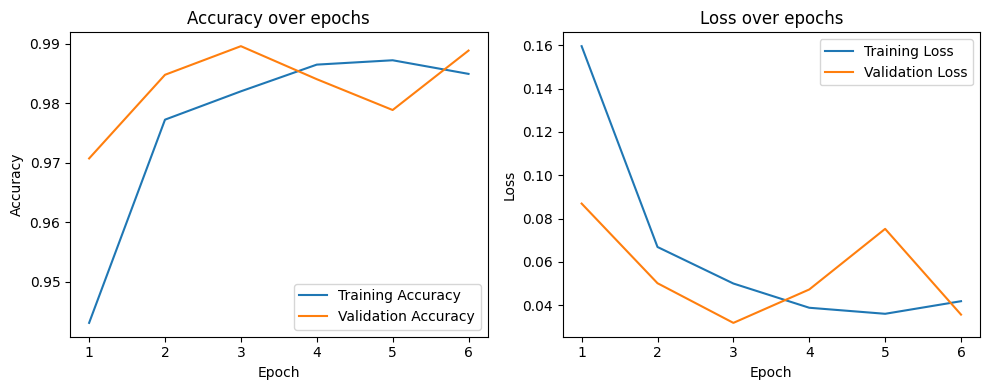

In [11]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(history.history['accuracy']) + 1)

# Accuracy plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### training performance analysis

From the plots above, we observe that:

- The **training and validation accuracy** both increase steadily and stay close to each other.
- The **loss** decreases for both training and validation sets, with minor fluctuations. 
- There is **no visible overfitting**: validation accuracy remains high and stable.

The model shows good generalization and stable learning over the training epochs.


## Make predictions and evaluate

We use the trained model to make predictions on the test set, compare them with the true labels, and assess performance using:

- A classification report
- A confusion matrix
- Visual examples of predictions

This gives a more detailed view of how well the model performs in practice.


In [12]:
import numpy as np

# Predict probabilities for all test images
pred_probs = model.predict(test_generator)

# Get the predicted class index (highest probability)
pred_classes = np.argmax(pred_probs, axis=1)

# Get the true class indices from the generator
true_classes = test_generator.classes

# Class labels (folder names, sorted alphabetically)
class_labels = list(test_generator.class_indices.keys())


85/85 ━━━━━━━━━━━━━━━━━━━━ 69s 795ms/step


Classification Report:

               precision    recall  f1-score   support

  freshapples       0.98      0.99      0.98       395
  freshbanana       0.99      1.00      1.00       381
 freshoranges       0.99      0.98      0.99       388
 rottenapples       0.99      0.98      0.99       601
 rottenbanana       1.00      1.00      1.00       530
rottenoranges       0.97      1.00      0.98       403

     accuracy                           0.99      2698
    macro avg       0.99      0.99      0.99      2698
 weighted avg       0.99      0.99      0.99      2698



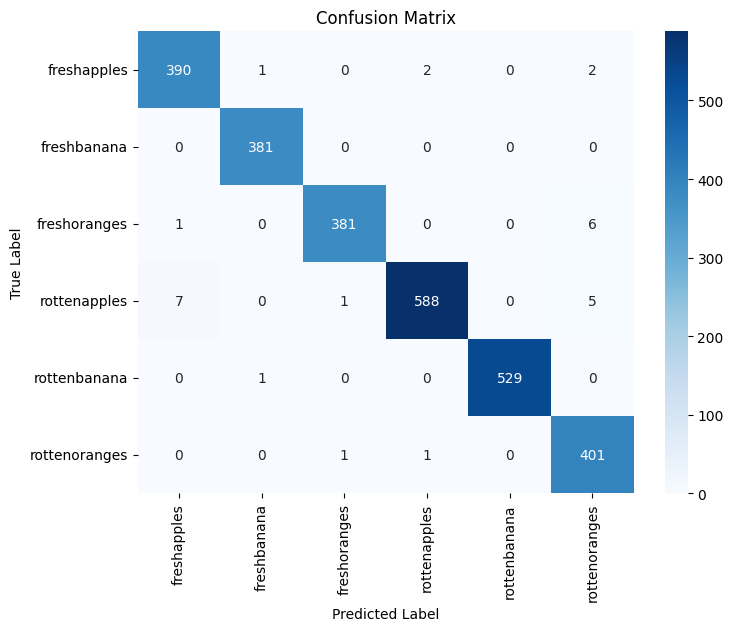

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print("Classification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


1. Classification report

The model achieves **very high performance across all 6 classes**, with an overall accuracy of **99%**.

| Metric      | Interpretation |
|-------------|----------------|
| **Precision** | Most predicted labels are correct (low false positives) |
| **Recall**    | Most real fruits are correctly identified (low false negatives) |
| **F1-score**  | Excellent balance between precision and recall |

The best performing classes include:
- freshbanana, rottenbanana: F1 = 1.00 (perfect)
- All others: F1 > 0.98

These results indicate the model is extremely reliable and generalizes well.

---

2. Confusion matrix

- Almost all predictions lie on the diagonal → meaning the predicted class matches the true label.
- A few errors occur:
  - Some rottenapples predicted as freshapples (7 cases)
  - Some freshoranges misclassified as rottenoranges (6 cases) ...

These confusions are understandable, as visual differences between slightly spoiled vs. fresh fruit can be subtle.


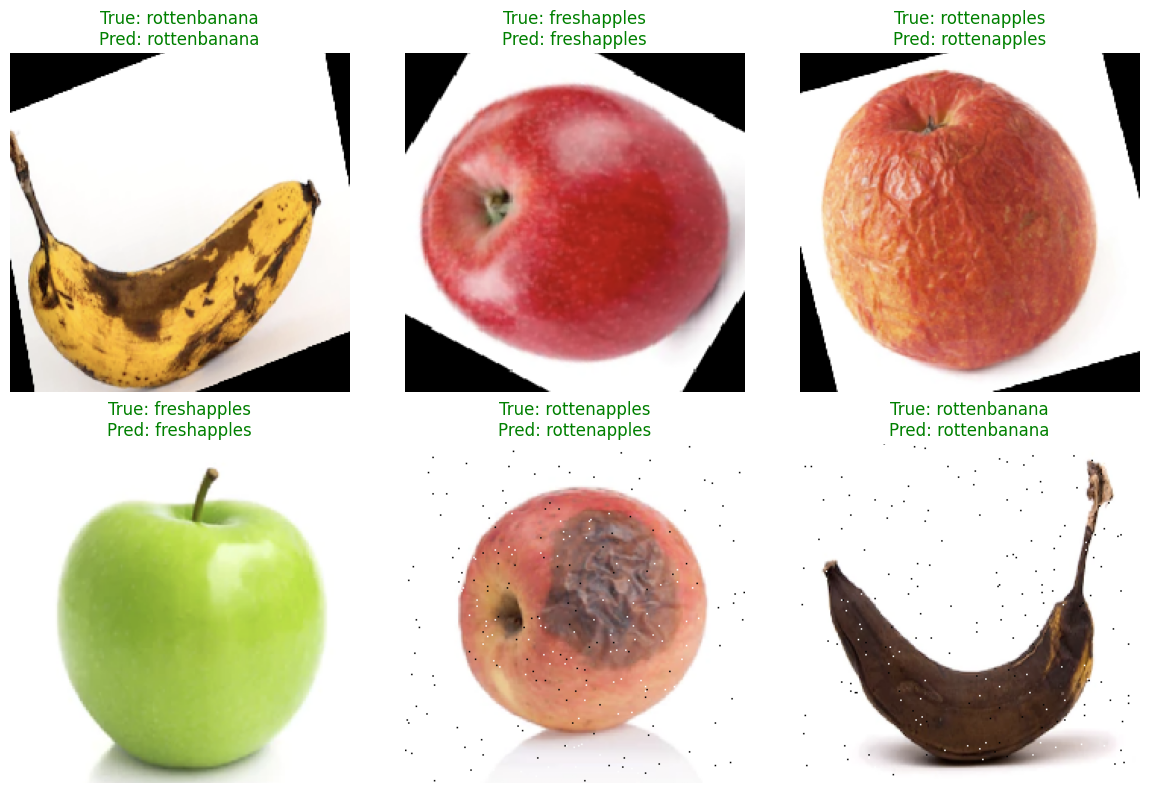

In [14]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random

# Get test image file paths
file_paths = test_generator.filepaths

# Show 6 random predictions
plt.figure(figsize=(12, 8))

for i in range(6):
    index = random.randint(0, len(file_paths) - 1)
    img_path = file_paths[index]

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0

    plt.subplot(2, 3, i+1)
    plt.imshow(img_array)
    plt.axis('off')

    true_label = class_labels[true_classes[index]]
    pred_label = class_labels[pred_classes[index]]
    color = 'green' if true_label == pred_label else 'red'

    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)

plt.tight_layout()
plt.show()


## Conclusion

This project demonstrates how deep learning can be used to automate fruit sorting by detecting rotten vs. fresh fruits.  
We built an image classifier using transfer learning with MobileNetV2, achieving:

- **99% accuracy** on a well-balanced dataset of 6 classes (fresh/rotten apples, bananas, oranges)
- Strong generalization with minimal overfitting
- Real-time prediction capability using a lightweight CNN backbone (MobileNetV2)

With data augmentation and early stopping, we ensured robustness and training stability.  
Evaluation via confusion matrix and classification report confirmed excellent performance across all categories.

---

### what this project shows

- How **transfer learning** can be applied efficiently with few resources
- How to process image datasets using `ImageDataGenerator`
- The importance of visualizing learning curves and evaluation results
- The potential of AI to support **smart agriculture** and **automated quality control**

---

### next steps (optional improvements)

- Extend the dataset to include other fruits or vegetables
- Build a simple **GUI or web app** to allow farmers to test the tool
- Incorporate object detection (to locate and segment fruit in the image)

---

